In [1]:
import xarray as xr
import numpy as np
import xesmf as xe
import glob

# Step 1: Prepare file list if you have several files for each ensembles
file_pattern = "/directory/data???.nc"
date="2026-02-12"

##################################################################################


file_list = sorted(glob.glob(file_pattern))

# Step 2: Initialize empty lists for each variable
t2m_list, msl_list, tp_list = [], [], []

# Step 3: Loop through each file, extract variables, and add time dimension
for i, file in enumerate(file_list):
    ds = xr.open_dataset(file, chunks={"ensemble_member": 10})

    time_val = np.datetime64(date) + np.timedelta64(i, 'D')

    for var, var_list in zip(["t2m", "msl", "tp"], [t2m_list, msl_list, tp_list]):
        if var in ds:
            var_data = ds[var].expand_dims(time=[time_val])
            var_list.append(var_data)
        else:
            print(f"Warning: {var} not found in {file}")

# Step 4: Concatenate each variable
t2m_all = xr.concat(t2m_list, dim='time')
msl_all = xr.concat(msl_list, dim='time')
tp_all = xr.concat(tp_list, dim='time')

/tmp/ipykernel_1174386/3390627781.py:21: FutureWarning: In a future version, xarray will not decode the variable 'lead_time' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(file, chunks={"ensemble_member": 10})
/tmp/ipykernel_1174386/3390627781.py:21: FutureWarning: In a future version, xarray will not decode the variable 'lead_time' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of enco

In [31]:
t2m_all

<xarray.DataArray 't2m' (time: 46, ensemble_member: 201, latitude: 361,
                         longitude: 720)> Size: 10GB
dask.array<concatenate, shape=(46, 201, 361, 720), dtype=float32, chunksize=(1, 10, 361, 720), chunktype=numpy.ndarray>
Coordinates:
  * time             (time) datetime64[s] 368B 2026-02-12 ... 2026-03-29
  * ensemble_member  (ensemble_member) int64 2kB 0 1 2 3 4 ... 197 198 199 200
  * latitude         (latitude) float64 3kB 90.0 89.5 89.0 ... -89.0 -89.5 -90.0
  * longitude        (longitude) float64 6kB 0.0 0.5 1.0 ... 358.5 359.0 359.5
    lead_time        (time) timedelta64[ns] 368B 0 days 1 days ... 45 days
    issuance         datetime64[ns] 8B 2026-02-12
    valid_time       (time) datetime64[ns] 368B 2026-02-12 ... 2026-03-29

### interpolate to EC grid

In [2]:
####interpolate to EC grid


ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(90.0, -90.1, -1.5)),
        "lon": (["lon"], np.arange(0.0, 360.0, 1.5)),
    }
)
regridder = xe.Regridder(t2m_all, ds_out, "bilinear", reuse_weights=False)

t2m_interp = regridder(t2m_all)
msl_interp = regridder(msl_all)
tp_interp = regridder(tp_all)

### make week 3 and 4 average for t2m and msl but weekly sum for tp

In [3]:
# Define week slices (0-based indexing)
week_slices = [(19, 25), (26, 32)]  # Week 3 and Week 4: days 19–25 and 26–32 for Thursday start

# Dictionary to hold all weekly averaged/summed data
weekly_data = {"t2m": [], "msl": [], "tp": []}

# Loop over weeks
for i, (start, end) in enumerate(week_slices):
    for varname, var_interp in zip(["t2m", "msl", "tp"], [t2m_interp, msl_interp, tp_interp]):
        time_slice = var_interp.isel(time=slice(start, end+1))
        
        if varname == "tp":
            week_stat = time_slice.sum(dim='time')  # Sum for total precipitation
        else:
            week_stat = time_slice.mean(dim='time')  # Mean for temperature and pressure
        
        week_stat = week_stat.expand_dims(week=[i+1])  # Week 3 → 3, Week 4 → 4
        weekly_data[varname].append(week_stat)

# Combine into a Dataset
weekly_dataset = xr.Dataset({
    var: xr.concat(weekly_data[var], dim='week') for var in weekly_data
})

# Optional: add metadata
weekly_dataset['t2m'].attrs['units'] = 'K'
weekly_dataset['msl'].attrs['units'] = 'Pa'
weekly_dataset['tp'].attrs['units'] = 'm'  # assuming 'tp' is in meters


# Save to NetCDF (optional)
#weekly_dataset.to_netcdf("spire_ai_20250626_weekly_avg_sum_week3_4.nc")



## Estimate probabilities

#### Retrive climatology quantile from AI Quest. 

The dates belongs to the assosiate excell file. For example if  the forecast issued on 20250626, then the week 3 is 20250714 and week 4 is 20250721. Replace "password" by your AI Quest password.

In [4]:
from AI_WQ_package import retrieve_evaluation_data
retrieve_evaluation_data.retrieve_20yr_quintile_clim('20260302','tas','password')
retrieve_evaluation_data.retrieve_20yr_quintile_clim('20260302','mslp','password')
retrieve_evaluation_data.retrieve_20yr_quintile_clim('20260302','pr','password')
retrieve_evaluation_data.retrieve_20yr_quintile_clim('20260309','tas','password')
retrieve_evaluation_data.retrieve_20yr_quintile_clim('20260309','mslp','password')
retrieve_evaluation_data.retrieve_20yr_quintile_clim('20260309','pr','password')

File '/climatologies/2026/tas_20yrCLIM_WEEKLYMEAN_quintiles_20260302.nc' has been downloaded to successfully.
File '/climatologies/2026/mslp_20yrCLIM_WEEKLYMEAN_quintiles_20260302.nc' has been downloaded to successfully.
File '/climatologies/2026/pr_20yrCLIM_WEEKLYSUM_quintiles_20260302.nc' has been downloaded to successfully.
File '/climatologies/2026/tas_20yrCLIM_WEEKLYMEAN_quintiles_20260309.nc' has been downloaded to successfully.
File '/climatologies/2026/mslp_20yrCLIM_WEEKLYMEAN_quintiles_20260309.nc' has been downloaded to successfully.
File '/climatologies/2026/pr_20yrCLIM_WEEKLYSUM_quintiles_20260309.nc' has been downloaded to successfully.


<xarray.DataArray 'pr' (quantile: 4, latitude: 121, longitude: 240)> Size: 929kB
[116160 values with dtype=float64]
Coordinates:
  * quantile   (quantile) float64 32B 0.2 0.4 0.6 0.8
  * latitude   (latitude) float64 968B 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude  (longitude) float64 2kB 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
    time       datetime64[ns] 8B 2026-03-09

In [5]:
tas_quintile_bounds_wk3 = xr.open_dataset("tas_20yrCLIM_WEEKLYMEAN_quintiles_20260302.nc")['tas'].squeeze('time')
tas_quintile_bounds_wk4 = xr.open_dataset("tas_20yrCLIM_WEEKLYMEAN_quintiles_20260309.nc")['tas'].squeeze('time')

mslp_quintile_bounds_wk3 = xr.open_dataset("mslp_20yrCLIM_WEEKLYMEAN_quintiles_20260302.nc")['mslp'].squeeze('time')
mslp_quintile_bounds_wk4 = xr.open_dataset("mslp_20yrCLIM_WEEKLYMEAN_quintiles_20260309.nc")['mslp'].squeeze('time')

TP_quintile_bounds_wk3 = xr.open_dataset("pr_20yrCLIM_WEEKLYSUM_quintiles_20260302.nc")['pr'].squeeze('time')
TP_quintile_bounds_wk4 = xr.open_dataset("pr_20yrCLIM_WEEKLYSUM_quintiles_20260309.nc")['pr'].squeeze('time')


In [6]:
t2m_forecasts_wk3=weekly_dataset.sel(week=1).t2m.rename({'lat':'latitude','lon':'longitude'})
t2m_forecasts_wk4=weekly_dataset.sel(week=2).t2m.rename({'lat':'latitude','lon':'longitude'})
msl_forecasts_wk3=weekly_dataset.sel(week=1).msl.rename({'lat':'latitude','lon':'longitude'})
msl_forecasts_wk4=weekly_dataset.sel(week=2).msl.rename({'lat':'latitude','lon':'longitude'})
tp_forecasts_wk3=weekly_dataset.sel(week=1).tp.rename({'lat':'latitude','lon':'longitude'})
tp_forecasts_wk4=weekly_dataset.sel(week=2).tp.rename({'lat':'latitude','lon':'longitude'})


If needed multiply 1000 to change the unit of precipitation otherwise ignore this part

In [7]:
tp_forecasts_wk3=tp_forecasts_wk3*1000#.isel(ensemble_member=100).plot()
tp_forecasts_wk4=tp_forecasts_wk4*1000

#### Function to estimate probailites using "counting members" method 


In [10]:
def categorize_into_quintiles(forecast_week, quintile_bounds):
    """
    forecast_week: (ensemble_member, lat, lon)
    quintile_bounds: (quantile=4, lat, lon)
    Returns:
        probabilities: (quintile=5, lat, lon)
    """
    quantile_edges = xr.concat([
        xr.full_like(quintile_bounds.isel(quantile=0), -np.inf),
        quintile_bounds.isel(quantile=0),
        quintile_bounds.isel(quantile=1),
        quintile_bounds.isel(quantile=2),
        quintile_bounds.isel(quantile=3),
        xr.full_like(quintile_bounds.isel(quantile=0), np.inf)
    ], dim='edge')

    counts = []
    for q in range(5):
        in_bin = ((forecast_week > quantile_edges.isel(edge=q)) &
                  (forecast_week <= quantile_edges.isel(edge=q + 1)))
        prob = in_bin.sum(dim='ensemble_member') / forecast_week.sizes['ensemble_member']
        counts.append(prob)

    probs = xr.concat(counts, dim=xr.DataArray(np.arange(1, 6), dims="quintile"))
    return probs

#### calculating probabilites

In [11]:
probs_tas_wk3 = categorize_into_quintiles(t2m_forecasts_wk3, tas_quintile_bounds_wk3)
probs_tas_wk4 = categorize_into_quintiles(t2m_forecasts_wk4, tas_quintile_bounds_wk4)

probs_mslp_wk3 = categorize_into_quintiles(msl_forecasts_wk3, mslp_quintile_bounds_wk3)
probs_mslp_wk4 = categorize_into_quintiles(msl_forecasts_wk3, mslp_quintile_bounds_wk4)

probs_tp_wk3 = categorize_into_quintiles(tp_forecasts_wk3, TP_quintile_bounds_wk3)
probs_tp_wk4 = categorize_into_quintiles(tp_forecasts_wk3, TP_quintile_bounds_wk4)

In [32]:
probs_tas_wk3

<xarray.DataArray (quintile: 5, latitude: 121, longitude: 240)> Size: 1MB
dask.array<concatenate, shape=(5, 121, 240), dtype=float64, chunksize=(1, 121, 240), chunktype=numpy.ndarray>
Coordinates:
  * quintile   (quintile) int64 40B 1 2 3 4 5
  * latitude   (latitude) float64 968B 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude  (longitude) float64 2kB 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
    week       int64 8B 1
    issuance   datetime64[ns] 8B 2026-02-12
    quantile   float64 8B 0.2
    time       datetime64[ns] 8B 2026-03-02

## Forecast submission

In [12]:
from AI_WQ_package import forecast_submission

In [13]:
forecast_tas_wk3 = forecast_submission.AI_WQ_create_empty_dataarray('tas', '20260212', '1', 'SAIS2S', 'SAI', 'password')
forecast_tas_wk4 = forecast_submission.AI_WQ_create_empty_dataarray('tas', '20260212', '2', 'SAIS2S', 'SAI', 'password')

forecast_mslp_wk3 = forecast_submission.AI_WQ_create_empty_dataarray('mslp', '20260212', '1', 'SAIS2S', 'SAI', 'password')
forecast_mslp_wk4 = forecast_submission.AI_WQ_create_empty_dataarray('mslp', '20260212', '2', 'SAIS2S', 'SAI', 'password')

forecast_tp_wk3 = forecast_submission.AI_WQ_create_empty_dataarray('pr', '20260212', '1', 'SAIS2S', 'SAI', 'password')
forecast_tp_wk4 = forecast_submission.AI_WQ_create_empty_dataarray('pr', '20260212', '2', 'SAIS2S', 'SAI', 'password')

SAIS2S is registered to the AI Weather Quest. You may submit your forecast.
SAI is registered to the AI Weather Quest. You may submit your forecast.
   Unique_ID         expver_ID       Teamname      Modelname
0  bgzian_01    bgzimmerman_01    bgzimmerman    r01meridian
1  UWAtIA_01  UWAtmosNVIDIA_01  UWAtmosNVIDIA    DLESyMS2Sv1
2  yubi11_01       yubing11_01       yubing11   resaurora12h
3  TAICHI_01         TAICHI_01         TAICHI       TAICHIAI
4  NSFNAR_01        NSFNCAR_01        NSFNCAR  subCESMulator
5  Celece_01  CelestScience_01  CelestScience         Tellus
6  Nord2S_01      NordicS2S_01      NordicS2S     NordicS2S2
7  AIFCzz_01           AIFC_01           AIFC         WRcast
8  Nvidll_01  NvidiaDistill_01  NvidiaDistill      DLESyM10K
9  Nord2S_02      NordicS2S_02      NordicS2S     NordicS2S3
SAIS2S is registered to the AI Weather Quest. You may submit your forecast.
SAI is registered to the AI Weather Quest. You may submit your forecast.
    Unique_ID         expver_ID

In [14]:
forecast_tas_wk3.values=probs_tas_wk3
forecast_tas_wk4.values=probs_tas_wk4

In [33]:
probs_tas_wk3

<xarray.DataArray (quintile: 5, latitude: 121, longitude: 240)> Size: 1MB
dask.array<concatenate, shape=(5, 121, 240), dtype=float64, chunksize=(1, 121, 240), chunktype=numpy.ndarray>
Coordinates:
  * quintile   (quintile) int64 40B 1 2 3 4 5
  * latitude   (latitude) float64 968B 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude  (longitude) float64 2kB 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
    week       int64 8B 1
    issuance   datetime64[ns] 8B 2026-02-12
    quantile   float64 8B 0.2
    time       datetime64[ns] 8B 2026-03-02

In [ ]:
#forecast_tas_wk3.to_netcdf("tas_20260129_p1_SAIS2S.nc")
#forecast_tas_wk4.to_netcdf("tas_20260129_p2_SAIS2S.nc")

In [15]:
forecast_tas_wk3_submit = forecast_submission.AI_WQ_forecast_submission(forecast_tas_wk3,'tas', '20260212', '1', 'SAIS2S', 'SAI', 'password')
forecast_tas_wk4_submit = forecast_submission.AI_WQ_forecast_submission(forecast_tas_wk4,'tas', '20260212', '2', 'SAIS2S', 'SAI', 'password')


SAIS2S is registered to the AI Weather Quest. You may submit your forecast.
SAI is registered to the AI Weather Quest. You may submit your forecast.
forecast submitted within competition time window
Latitude found as 'latitude'
Longitude found as 'longitude'
Quintile found as 'quintile'
All data is between 0 and 1.
SAIS2S is registered to the AI Weather Quest. You may submit your forecast.
SAI is registered to the AI Weather Quest. You may submit your forecast.
    Unique_ID         expver_ID       Teamname      Modelname
0   bgzian_01    bgzimmerman_01    bgzimmerman    r01meridian
1   UWAtIA_01  UWAtmosNVIDIA_01  UWAtmosNVIDIA    DLESyMS2Sv1
2   yubi11_01       yubing11_01       yubing11   resaurora12h
3   TAICHI_01         TAICHI_01         TAICHI       TAICHIAI
4   NSFNAR_01        NSFNCAR_01        NSFNCAR  subCESMulator
5   Celece_01  CelestScience_01  CelestScience         Tellus
6   Nord2S_01      NordicS2S_01      NordicS2S     NordicS2S2
7   AIFCzz_01           AIFC_01       

In [17]:
forecast_mslp_wk3.values=probs_mslp_wk3
forecast_mslp_wk4.values=probs_mslp_wk4

In [18]:
#forecast_mslp_wk3.to_netcdf("mslp_20260129_p1_SAIS2S.nc")
#forecast_mslp_wk4.to_netcdf("mslp_20260129_p2_SAIS2S.nc")

In [19]:
forecast_mslp_wk3_submit = forecast_submission.AI_WQ_forecast_submission(forecast_mslp_wk3,'mslp', '20260212', '1', 'SAIS2S', 'SAI', 'password')
forecast_mslp_wk4_submit = forecast_submission.AI_WQ_forecast_submission(forecast_mslp_wk4,'mslp', '20260212', '2', 'SAIS2S', 'SAI', 'password')


SAIS2S is registered to the AI Weather Quest. You may submit your forecast.
SAI is registered to the AI Weather Quest. You may submit your forecast.
forecast submitted within competition time window
Latitude found as 'latitude'
Longitude found as 'longitude'
Quintile found as 'quintile'
All data is between 0 and 1.
SAIS2S is registered to the AI Weather Quest. You may submit your forecast.
SAI is registered to the AI Weather Quest. You may submit your forecast.
    Unique_ID         expver_ID       Teamname      Modelname
0   bgzian_01    bgzimmerman_01    bgzimmerman    r01meridian
1   UWAtIA_01  UWAtmosNVIDIA_01  UWAtmosNVIDIA    DLESyMS2Sv1
2   yubi11_01       yubing11_01       yubing11   resaurora12h
3   TAICHI_01         TAICHI_01         TAICHI       TAICHIAI
4   NSFNAR_01        NSFNCAR_01        NSFNCAR  subCESMulator
5   Celece_01  CelestScience_01  CelestScience         Tellus
6   Nord2S_01      NordicS2S_01      NordicS2S     NordicS2S2
7   AIFCzz_01           AIFC_01       

In [20]:
forecast_tp_wk3.values=probs_tp_wk3
forecast_tp_wk4.values=probs_tp_wk4

In [21]:
#forecast_tp_wk3.to_netcdf("pr_20260129_p1_SAIS2S.nc")
#forecast_tp_wk4.to_netcdf("pr_20260129_p2_SAIS2S.nc")

In [22]:
forecast_tp_wk3_submit = forecast_submission.AI_WQ_forecast_submission(forecast_tp_wk3,'pr', '20260212', '1', 'SAIS2S', 'SAI', 'password')
forecast_tp_wk4_submit = forecast_submission.AI_WQ_forecast_submission(forecast_tp_wk4,'pr', '20260212', '2', 'SAIS2S', 'SAI', 'password')


SAIS2S is registered to the AI Weather Quest. You may submit your forecast.
SAI is registered to the AI Weather Quest. You may submit your forecast.
forecast submitted within competition time window
Latitude found as 'latitude'
Longitude found as 'longitude'
Quintile found as 'quintile'
All data is between 0 and 1.
SAIS2S is registered to the AI Weather Quest. You may submit your forecast.
SAI is registered to the AI Weather Quest. You may submit your forecast.
    Unique_ID         expver_ID       Teamname      Modelname
0   bgzian_01    bgzimmerman_01    bgzimmerman    r01meridian
1   UWAtIA_01  UWAtmosNVIDIA_01  UWAtmosNVIDIA    DLESyMS2Sv1
2   yubi11_01       yubing11_01       yubing11   resaurora12h
3   TAICHI_01         TAICHI_01         TAICHI       TAICHIAI
4   NSFNAR_01        NSFNCAR_01        NSFNCAR  subCESMulator
5   Celece_01  CelestScience_01  CelestScience         Tellus
6   Nord2S_01      NordicS2S_01      NordicS2S     NordicS2S2
7   AIFCzz_01           AIFC_01       

Plotting forecast

In [25]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.colors as mcolors

def plot_ecmwf_quintile_discrete(q5_da, title="Prob. of quintile 80<=x<100 for T2M forecast_issue_date:20260212.forecast period:20260302 to 20260309 "):
                                  #period_label="Mon 30 Jun 2025 – Mon 07 Jul 2025"):

    # Convert to %
    data = 100 * q5_da

    # ECMWF bin levels
    levels = [0, 5, 10, 15, 20, 25, 33, 40, 50, 60, 70, 80, 90, 100]

    # ECMWF color approximation
    ecmwf_colors = [
        "#8000A8", "#665DC1", "#0000FF", "#0070DD", "#00A5C9",
        "#00E0DD", "#6CF3C6", "#4CE07F", "#A5E400", "#F0F300",
        "#FFCC00", "#FF9900", "#FF4D00", "#E60000"
    ]
    cmap = mcolors.ListedColormap(ecmwf_colors)
    norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=len(ecmwf_colors))

    # Plot
    fig = plt.figure(figsize=(13, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())

    mesh = ax.pcolormesh(
        data.longitude, data.latitude, data,
        cmap=cmap, norm=norm, shading='auto', transform=ccrs.PlateCarree()
    )

    ax.coastlines(resolution='110m', linewidth=0.7)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.set_global()

    plt.title(title, fontsize=14)
    #plt.suptitle(f"Forecast period: {period_label}", fontsize=11, y=0.91)

    cbar = plt.colorbar(mesh, orientation='horizontal', pad=0.05, aspect=50, ticks=levels)
    cbar.set_label('%')

    plt.tight_layout()
    plt.show()


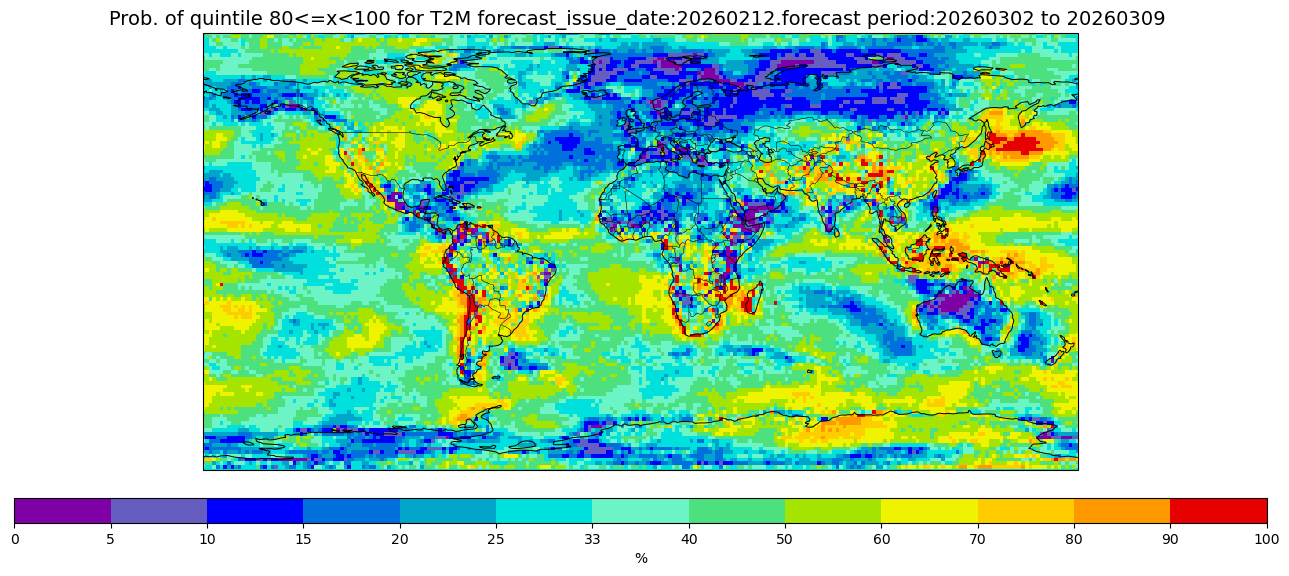

In [30]:
q5 = probs_tas_wk3.sel(quintile=5)  # assuming 1.0 is 80–100% bin

plot_ecmwf_quintile_discrete(
    q5,
    #title="Surface temperature: Probability distribution",
    #period_label="Mon 30 Jun 2025 – Mon 07 Jul 2025"
)